In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

In [ ]:
%pip install git+https://github.com/RobustBench/robustbench
%pip install git+https://github.com/alirezaabdollahpour/SuperDeepFool.git
%pip install -q foolbox

  Cloning https://github.com/RobustBench/robustbench to /tmp/pip-req-build-joi_linh
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench /tmp/pip-req-build-joi_linh
  Resolved https://github.com/RobustBench/robustbench to commit 78fcc9e48a07a861268f295a777b975f25155964
  Preparing metadata (setup.py) ... done
  Using cached autoattack-0.1-py3-none-any.whl
  Cloning https://github.com/alirezaabdollahpour/SuperDeepFool.git to /tmp/pip-req-build-empzeyds
  Running command git clone --filter=blob:none --quiet https://github.com/alirezaabdollahpour/SuperDeepFool.git /tmp/pip-req-build-empzeyds
  Resolved https://github.com/alirezaabdollahpour/SuperDeepFool.git to commit 20f75b24a817309da73ea043e9f37dd80c07fa3f
  Preparing metadata (setup.py) ... done


In [ ]:
from robustbench import load_cifar10, load_model
import os
import logging
import math
import torch
import foolbox as fb

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(8)

os.makedirs(os.path.join('data', 'torchvision'), exist_ok=True)
os.makedirs(os.path.join('results', 'cifar10'), exist_ok=True)

n_examples = 10000 # get all eval examples
images, labels = load_cifar10(n_examples=n_examples, data_dir='data')
test_dataset = torch.utils.data.TensorDataset(images, labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(test_dataset))

10000


In [ ]:
def per_class_accuracy(model: nn.Module,
                       x: torch.Tensor,
                       y: torch.Tensor,
                       n_classes: int = 10,
                       batch_size: int = 100,
                       device: torch.device = None):
    if device is None:
        device = x.device

    class_correct = torch.zeros(n_classes)
    class_total = torch.zeros(n_classes)

    n_batches = math.ceil(x.shape[0] / batch_size)
    with torch.no_grad():
        for counter in range(n_batches):
            x_curr = x[counter * batch_size:(counter + 1) * batch_size].to(device)
            y_curr = y[counter * batch_size:(counter + 1) * batch_size].to(device)

            output = model(x_curr)
            predictions = output.max(1)[1]

            for c in range(n_classes):
                mask = (y_curr == c)
                class_total[c] += mask.sum().item()
                class_correct[c] += ((predictions == y_curr) & mask).sum().item()

    class_accuracies = class_correct / class_total
    overall_accuracy = class_correct.sum().item() / class_total.sum().item()

    return overall_accuracy, class_accuracies

In [ ]:
batch_size = 100

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Standard model
base_model = load_model(model_name='Standard', dataset='cifar10')
torch.cuda.empty_cache()
acc_orig, per_class_orig = per_class_accuracy(base_model.to(device), images, labels,
                                               batch_size=batch_size, device=device)
print(f"Overall Accuracy: {acc_orig:.4f}\n")
print("Per-class Accuracy (Standard Model):")
for i, (name, acc) in enumerate(zip(class_names, per_class_orig)):
    print(f"  {name:12s}: {acc:.4f}")

print("\n" + "="*50 + "\n")

# Adversarially-trained model
at_model = load_model(model_name='Rice2020Overfitting', dataset='cifar10')
torch.cuda.empty_cache()
acc_at, per_class_at = per_class_accuracy(at_model.to(device), images, labels,
                                          batch_size=batch_size, device=device)
print(f"Overall Accuracy: {acc_at:.4f}\n")
print("Per-class Accuracy (Adversarially-Trained Model):")
for i, (name, acc) in enumerate(zip(class_names, per_class_at)):
    print(f"  {name:12s}: {acc:.4f}")

Overall Accuracy: 0.9478

Per-class Accuracy (Standard Model):
  airplane    : 0.9680
  automobile  : 0.9770
  bird        : 0.9210
  cat         : 0.8780
  deer        : 0.9540
  dog         : 0.9260
  frog        : 0.9630
  horse       : 0.9610
  ship        : 0.9650
  truck       : 0.9650


Overall Accuracy: 0.8534

Per-class Accuracy (Adversarially-Trained Model):
  airplane    : 0.8770
  automobile  : 0.9350
  bird        : 0.7050
  cat         : 0.7070
  deer        : 0.8830
  dog         : 0.7050
  frog        : 0.9180
  horse       : 0.8950
  ship        : 0.9640
  truck       : 0.9450


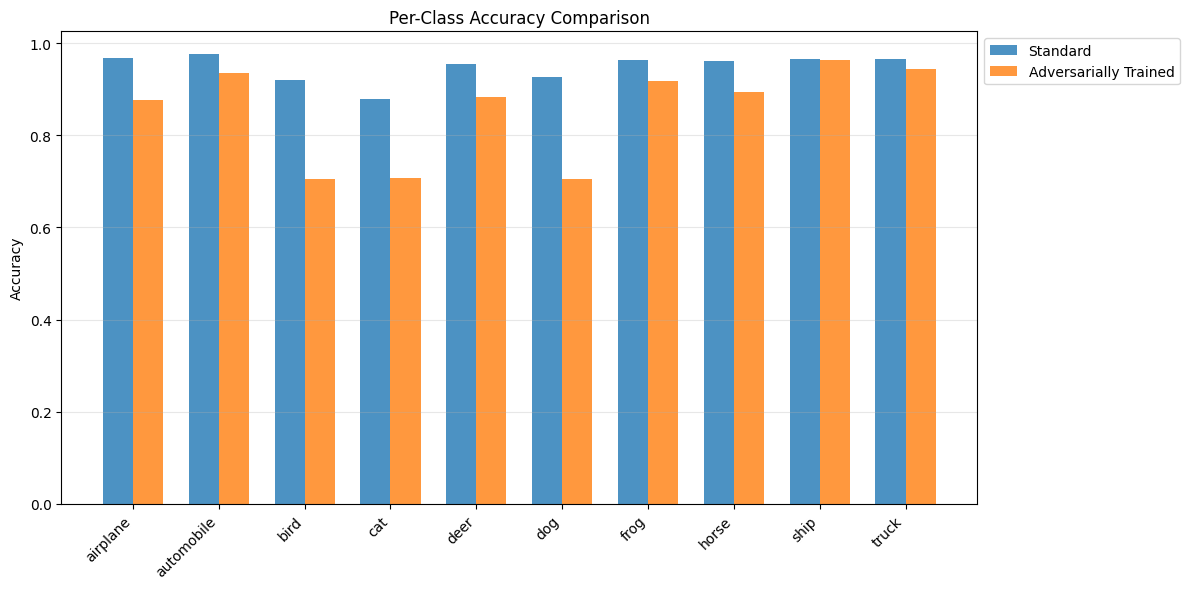

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Comparison plot
x = np.arange(len(class_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, per_class_orig, width, label='Standard', alpha=0.8)
bars2 = ax.bar(x + width/2, per_class_at, width, label='Adversarially Trained', alpha=0.8)

ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/cifar10/per_class_accuracy.png', dpi=300)
plt.show()

In [ ]:
base_fmodel = fb.PyTorchModel(base_model, bounds=(0, 1))
at_fmodel = fb.PyTorchModel(base_model, bounds=(0, 1))

_, base_advs, base_success = fb.attacks.LinfPGD()(base_fmodel, images.to('cuda:0'), labels.to('cuda:0'), epsilons=[8/255])
print('Robust accuracy (Standard Model): {:.1%}'.format(1 - base_success.float().mean()))

_, at_advs, at_success = fb.attacks.LinfPGD()(base_fmodel, images.to('cuda:0'), labels.to('cuda:0'), epsilons=[8/255])
print('Robust accuracy (Standard Model): {:.1%}'.format(1 - at_success.float().mean()))

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.10 GiB. GPU 0 has a total capacity of 14.74 GiB of which 4.56 GiB is free. Process 2584 has 10.18 GiB memory in use. Of the allocated memory 9.37 GiB is allocated by PyTorch, and 688.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)